In [1]:
import matplotlib as mpl
from TrainedModels import *
from Datasets import *
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import h5py as h5
from glob import glob
from Visualise import *
from MMD.mmd import MMD_3_Sample_Test
from scipy.stats import ks_2samp

from nystrom_kexpfam.hamiltonian import compute_avg_acceptance

%matplotlib inline

KERNEL_HMC: INFO: 2018-07-06 20:18:57,254: log.<module>(): Global logger initialised with loglevel 20


## Visualise data

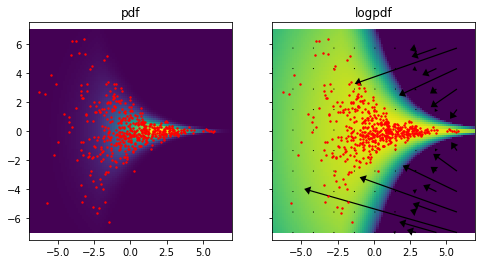

In [2]:
D = 2
p = Funnel(sigma=2, D=D, lim=10)
#p = Spiral(D=D)
#p = Ring(D=D, sigma=0.1)
#p = Banana(bananicity=0.2, sigma=3, D=D)
#p = RedWine()
#D = p.D

plot_size=14
ngrid = 100
eval_grid = np.linspace(-plot_size/2, plot_size/2, ngrid)
sample_params = dict()
dlogpdf_params = dict(vmin=-50)
quiver_params=dict(scale=10000, headaxislength=5,headlength=5, headwidth=7)

fig, axes, rand_train_data, eval_grid, eval_points  = plot_dataset(p, plot_size, ngrid, n=500,
                                          sample_params=sample_params, dlogpdf_params = dlogpdf_params, quiver_params=quiver_params);

In [3]:
l = 3           # number of layers
seed = 1       # random seed used for training
npoint = 150    # number of inducing points
niter = 10000   # number of iterations ran during training
ndim = 10       # number of neurons per layer
step_size = 1e-2
alg = "Adam"

fn = "%s_D%02d_l%d_nd%d_np%d_nv%d_tp2_ss%d_ni%d_a%s_s%02d" % (p.name[0], p.D, l, ndim, npoint, npoint, step_size*1000, niter, alg[0], seed)

ntrain = npoint

### Visualize the trained model

INFO:tensorflow:Restoring parameters from ckpts/f_D02_l3_nd10_np150_nv150_tp2_ss10_ni10000_aA_s01.ckpt


KERNEL_HMC: INFO: 2018-07-06 20:19:00,477: tf_logging.info(): Restoring parameters from ckpts/f_D02_l3_nd10_np150_nv150_tp2_ss10_ni10000_aA_s01.ckpt


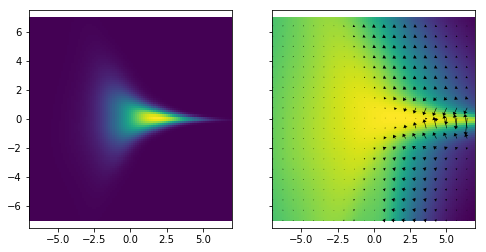

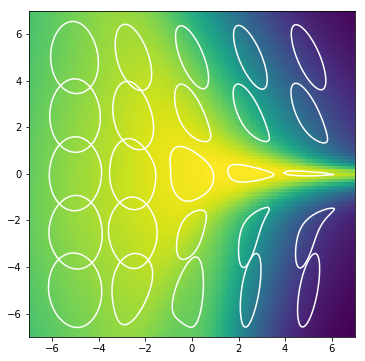

In [4]:
np.random.seed(1234)

# train the model using 1000 points, 150 which which are used as inducing points
rand_train_data = p.sample(1000)
kn_model = TrainedDeepLite(fn, rand_train_data, points_type="sep", npoint = 150)

# logp
fv_value = kn_model.fun_multiple(eval_points)
# dlogp
gv_value = kn_model.grad_multiple(eval_points, batch_size = 100)


fv_value = fv_value.reshape(ngrid,ngrid)
gv_value = gv_value.reshape(ngrid,ngrid,D)

logpdf   = fv_value-fv_value.max()+10
pdf      = np.exp(logpdf)
pdf /= pdf.sum()
pdf = pdf.reshape(ngrid, ngrid)


fig, axes = plt.subplots(1,2,figsize=(8,4),sharex=True, sharey=True)

ax = axes[0]
ax.pcolor(eval_grid, eval_grid, pdf.T)
plt.xlim([-plot_size/2,plot_size/2])
plt.ylim([-plot_size/2,plot_size/2])
ax.set_aspect("equal")

ax = axes[1]

ax.pcolor(eval_grid, eval_grid, logpdf.T)
g_int = 5
ax.quiver(eval_grid[::g_int], eval_grid[::g_int], gv_value[::g_int,::g_int,0].T, 
           gv_value[::g_int,::g_int,1].T, scale=300, headaxislength=5,headlength=5, headwidth=7)
#ax.scatter(rand_train_data[:,0], rand_train_data[:,1], 3, "w")
#ax.scatter(kn_model.rand_points[:,0], kn_model.rand_points[:,1], 20, "C1", marker="x")
plt.xlim([-plot_size/2,plot_size/2])
plt.ylim([-plot_size/2,plot_size/2])
ax.set_aspect("equal")

# plot kernel function if D == 2
if D == 2:
    ncenter= 5
    points_grid = np.array([[i,j] for i in np.linspace(-plot_size/2+2,plot_size/2-2,ncenter) for j in np.linspace(-plot_size/2+2,plot_size/2-2,ncenter)])

    plt.figure(figsize=(6,6))
    K = visualize_kernel(kn_model, np.linspace(-plot_size/2,plot_size/2,200), [0.99], points=points_grid, colors="white")

    plt.pcolor(np.linspace(-plot_size/2,plot_size/2,ngrid),np.linspace(-plot_size/2,plot_size/2,ngrid),
               logpdf.T)
    plt.gca().set_aspect("equal")

### Evaluate acceptance probability

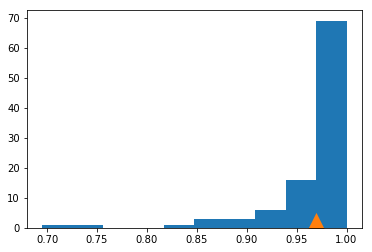

In [5]:
sigma_p=1 # momentum std deviation
step_size=0.05
num_steps=20
nchain = 100

logq = lambda x: p.logpdf(x)
dlogq = lambda x : kn_model.grad(x)
#dlogq = lambda x : p.grad_multiple(x[None,:])[0]

acc_means = np.zeros(nchain)

q0 = p.sample(nchain)

for i in range(nchain):
        
    am  = compute_avg_acceptance(q0[i], logq, dlogq, sigma_p, num_steps, step_size,plot=False)
    if am == np.inf:
        am = 0
    acc_means[i] = am
    

plt.hist(acc_means)
plt.plot(acc_means.mean(), 0, "^", ms=20, mew=5)

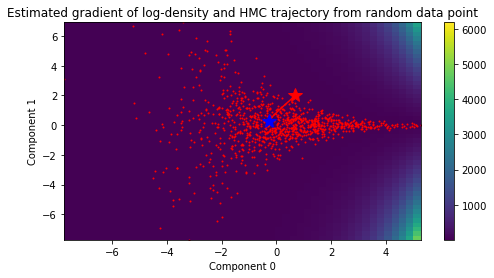

Average acceptance rate along trajectory: 1.00


In [6]:
plot_i, plot_j = 0,1
fig=plt.figure(figsize=(8,4))

plot_only_trajectory = (rand_train_data.shape[1]!=2) # only plot density if space is 2D, otherwise only projected samples

i = np.random.randint(0, nchain)

acc_mean = compute_avg_acceptance(q0[i], logq, dlogq, sigma_p, num_steps, step_size,
                       plot=True, X=rand_train_data, est_grad=p.grad_multiple, plot_i=plot_i, plot_j=plot_j, ax=fig.add_subplot(111),
                                  plot_only_trajectory=plot_only_trajectory)
print "Average acceptance rate along trajectory: %.2f" % acc_mean

In [7]:
nsample = 1000
thin = 1
kn_model.setup_mcmc(num_steps_min=10, num_steps_max=10, step_size_min=0.1, step_size_max=1.0)
model_samples = kn_model.sample(nsample*thin, rand_train_data[1])
model_samples = model_samples[::thin]
true_samples = p.sample(nsample)

KERNEL_HMC: INFO: 2018-07-06 20:19:15,282: mini_mcmc.mini_mcmc(): Starting MCMC using KMCStatic in D=2 dimensions
KERNEL_HMC: INFO: 2018-07-06 20:19:20,326: mini_mcmc.mini_mcmc(): MCMC iteration 111/1000, current log_pdf: 29.978434, avg acceptance: 0.664
KERNEL_HMC: INFO: 2018-07-06 20:19:25,369: mini_mcmc.mini_mcmc(): MCMC iteration 220/1000, current log_pdf: 27.406509, avg acceptance: 0.648
KERNEL_HMC: INFO: 2018-07-06 20:19:30,403: mini_mcmc.mini_mcmc(): MCMC iteration 327/1000, current log_pdf: 30.707512, avg acceptance: 0.672
KERNEL_HMC: INFO: 2018-07-06 20:19:35,411: mini_mcmc.mini_mcmc(): MCMC iteration 433/1000, current log_pdf: 33.293560, avg acceptance: 0.657
KERNEL_HMC: INFO: 2018-07-06 20:19:40,437: mini_mcmc.mini_mcmc(): MCMC iteration 541/1000, current log_pdf: 32.621834, avg acceptance: 0.667
KERNEL_HMC: INFO: 2018-07-06 20:19:45,441: mini_mcmc.mini_mcmc(): MCMC iteration 648/1000, current log_pdf: 32.863148, avg acceptance: 0.652
KERNEL_HMC: INFO: 2018-07-06 20:19:50,47

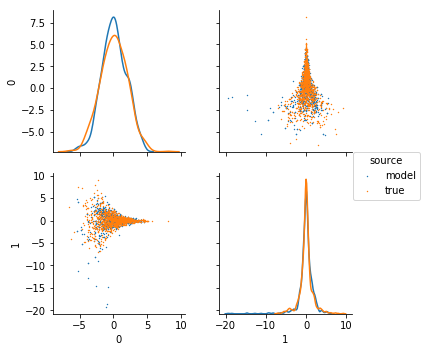

In [8]:
import seaborn as sns
import pandas as pd

true_samples = p.sample(nsample)
model_sample_df = pd.DataFrame(model_samples)
model_sample_df["source"] = "model"

true_sample_df = pd.DataFrame(true_samples)
true_sample_df["source"] = "true"

sample_df = pd.concat([model_sample_df, true_sample_df])

sns.pairplot(sample_df, hue="source", size=2.5, diag_kind="kde",
            plot_kws=dict(s=2, alpha=1, linewidth=0),)

In [9]:
ks_2samp(true_samples[:,1], model_samples[:,1])

Ks_2sampResult(statistic=0.043249249249249333, pvalue=0.3009486757910893)

In [10]:
MMD_3_Sample_Test(p.sample(nsample-1), p.sample(nsample-1), model_samples)

(0.92204400403673092, -1.4189554936793847, 1.8682730142823232, None, None)